In [3]:
import sys
import os

# Add the path to your 'scripts' directory
scripts_dir = os.path.abspath('../scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
# Import necessary functions from the module
    # Import necessary functions from the module
from query_data import fetch_data
from data_cleaning import check_missing_values, drop_na_in_columns, check_missing_values_columns,find_duplicates
from overview_eda import get_top_manufacturers,get_top_manufacturers,get_top_handsets_per_manufacturer,get_top_handsets_by_type
# Import functions from the user behavior analysis module
from user_behavior_analysis import aggregate_user_behaviour, get_skewness, get_kurtosis, plot_box_plots, plot_violin_plots, plot_correlation_matrix, perform_pca, perform_pca_multiple_components
from data_base_cl import DB_Client
from user_engagement_analysis import (
    aggregate_metrics, top_n_customers, normalize_data,
    run_kmeans, elbow_method, compute_cluster_metrics,
    aggregate_traffic_per_application, aggregate_traffic_per_application
)
from user_experience import aggregate_user_experience, compute_top_bottom_frequent, compute_satisfaction_score, plot_throughput_per_handset, plot_tcp_retransmissions_per_handset, perform_kmeans_clustering

In [4]:
# Step 2: Define your SQL query
query = "SELECT * FROM xdr_data LIMIT 10;"  # Update the table name if needed

# Step 3: Fetch the data from PostgreSQL
data = fetch_data(query)

# Step 4: Check if the data is fetched successfully and display the first few rows
if data is not None:
    print("Data fetched successfully!")
    print(data.head())  # Display the first 5 rows of the data
else:
    
    print("No data fetched.")

Data fetched successfully.
Data fetched successfully!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L

## 1) Data Cleaning

In [5]:
# obtain values form environment variables
host = os.getenv("DB_HOST")
user_name = os.getenv("DB_USER")
passowrd = os.getenv("DB_PASSWORD")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")
db_client = DB_Client(
    host=host,
    user_name=user_name,
    password=passowrd,
    port=port,
    database_name=database
)

data = db_client.dump_data()

d:\Desktop\Tellco-Profitability-Analysis\scripts\data_base_cl.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  response = pd.read_sql_query(sql=query, con=self.connection)


In [4]:
data.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [6]:
data.isna().mean()

Bearer Id                                   0.006607
Start                                       0.000007
Start ms                                    0.000007
End                                         0.000007
End ms                                      0.000007
Dur. (ms)                                   0.000007
IMSI                                        0.003800
MSISDN/Number                               0.007107
IMEI                                        0.003813
Last Location Name                          0.007687
Avg RTT DL (ms)                             0.185525
Avg RTT UL (ms)                             0.185412
Avg Bearer TP DL (kbps)                     0.000007
Avg Bearer TP UL (kbps)                     0.000007
TCP DL Retrans. Vol (Bytes)                 0.587636
TCP UL Retrans. Vol (Bytes)                 0.644322
DL TP < 50 Kbps (%)                         0.005027
50 Kbps < DL TP < 250 Kbps (%)              0.005027
250 Kbps < DL TP < 1 Mbps (%)               0.

### What the Data Indicates
Columns with No Missing Values:
Columns like Bearer Id, Start, End, Total UL (Bytes), etc., have 0.0 as their missing value proportion, meaning there are no missing values in these columns.

Columns with Partial Missing Values:
Some columns have a proportion of missing values:

Avg RTT DL (ms) and Avg RTT UL (ms) have 0.5, meaning 50% of their data is missing.
TCP DL Retrans. Vol (Bytes) has 0.8, indicating 80% of its values are missing.
TCP UL Retrans. Vol (Bytes) has 0.9, meaning 90% of its data is missing.

In [7]:
cleaned_data = aggregate_user_experience(data)
print("Cleaned Data with Aggregated User Experience:")
print(cleaned_data.head())

Cleaned Data with Aggregated User Experience:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0  9.16456699548519E+015  ...           2501332.0           8198936.0   
1                L77566A  

1. **Parameters for Aggregation**:
   - Selected metrics include retransmissions, average round-trip time (RTT), and average bearer throughput for both downlink (DL) and uplink (UL).

2. **Handling Missing and Outlier Values**:
   - Missing values (`NaN`) for the specified parameters are replaced with the mean value of each column.
   - Outliers are identified using the interquartile range (IQR) method:
     - Outliers falling below `Q1 - 1.5 * IQR` or above `Q3 + 1.5 * IQR` are replaced with the column's mean value.

3. **Creation of a New Column**:
   - A new column, `TCP Retransmissions`, is introduced, representing the sum of TCP DL Retransmission Volume and TCP UL Retransmission Volume.

4. **Sample Data Output**:
   - The output displays the first few rows of the cleaned dataset (`cleaned_data`) with the aggregated and modified values.
   - Columns like `Bearer Id`, `Start`, `End`, and various throughput and retransmission metrics have been adjusted based on the cleaning process.

#### Key Observations:
- Missing and outlier values in metrics such as `Avg RTT DL (ms)` and `Avg Bearer TP DL (kbps)` have been replaced with calculated mean values.
- The new `TCP Retransmissions` column aggregates retransmission volumes for a comprehensive view of network retransmissions.

The cleaned dataset is now ready for further analysis or modeling, providing consistent and reliable data after handling anomalies and aggregating relevant metrics.


In [7]:
data.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


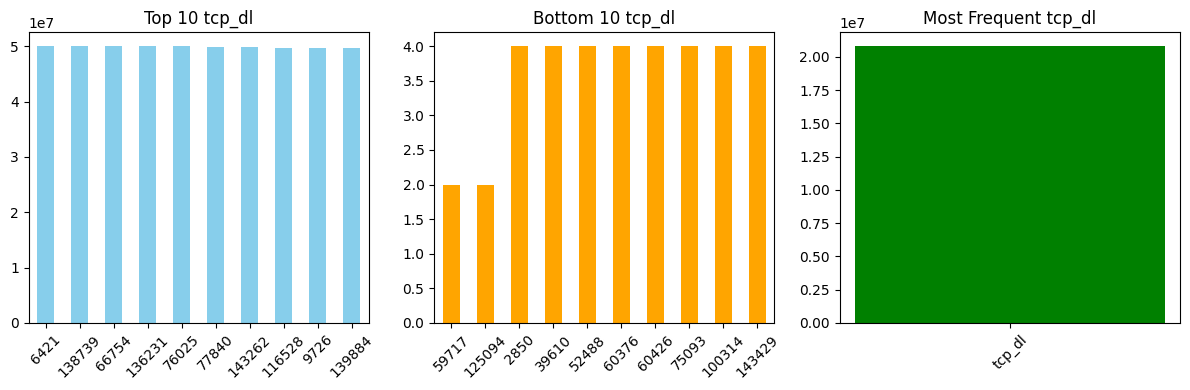

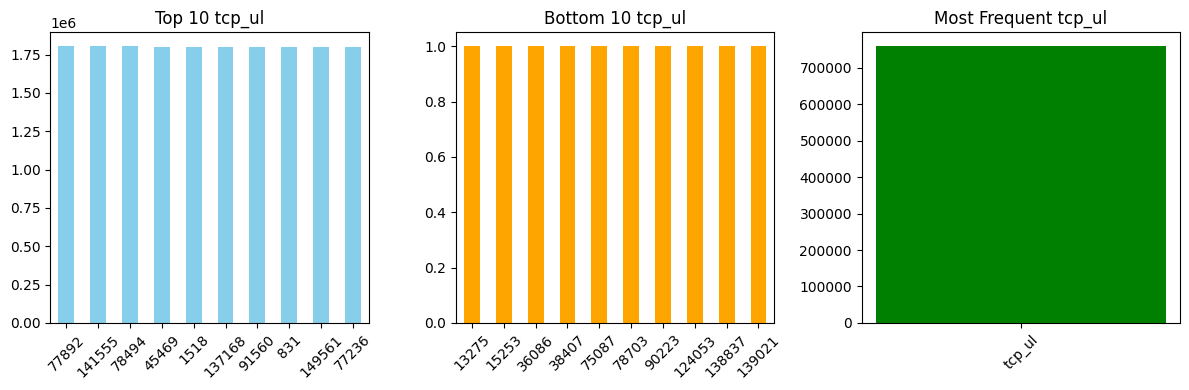

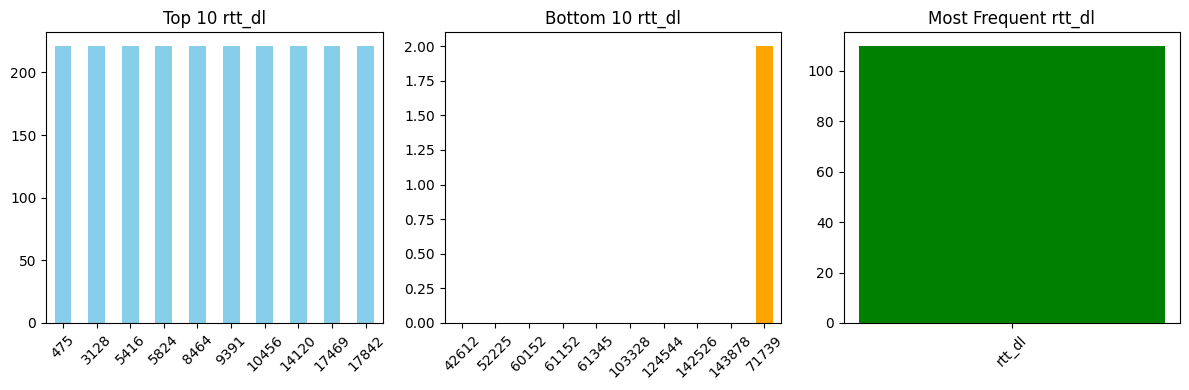

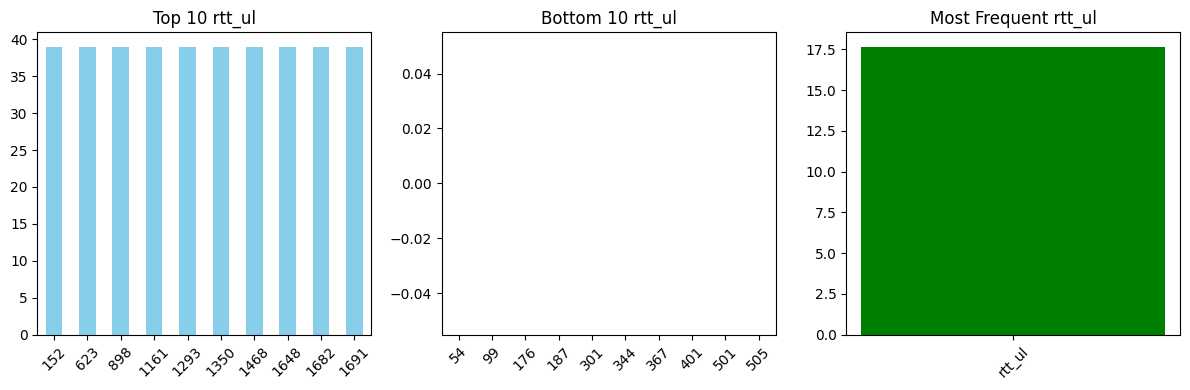

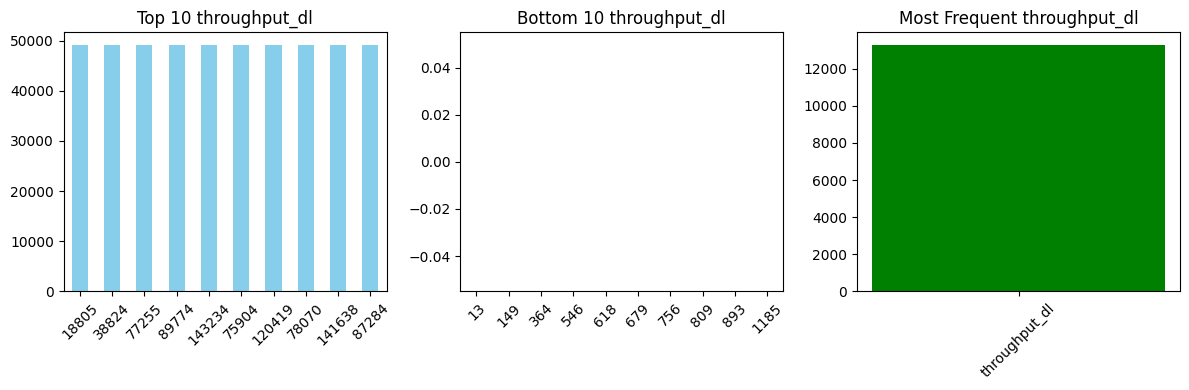

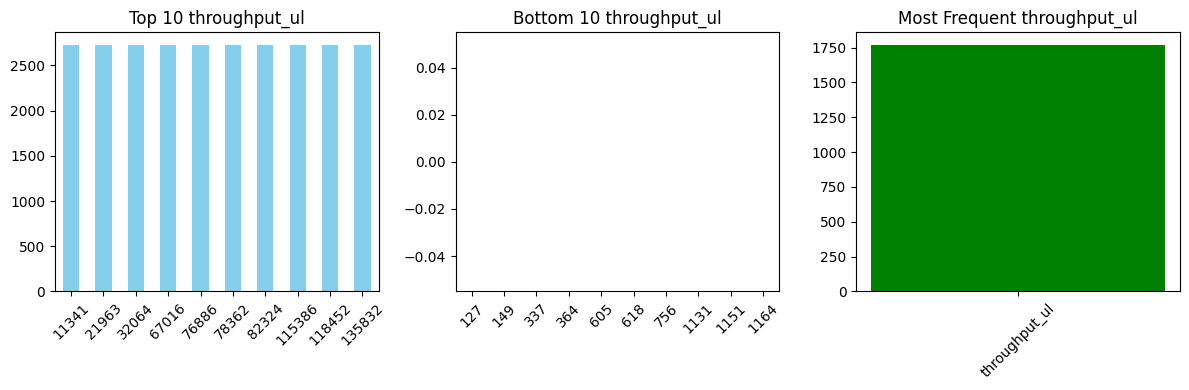

Top 10 TCP DL retransmissions:
6421      50021024.0
138739    49991791.0
66754     49986834.0
136231    49986038.0
76025     49969605.0
77840     49921268.0
143262    49833677.0
116528    49779123.0
9726      49777538.0
139884    49663906.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64
Bottom 10 RTT DL:
42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103328    0.0
124544    0.0
142526    0.0
143878    0.0
71739     2.0
Name: Avg RTT DL (ms), dtype: float64
Most frequent throughput UL:
1770.4286466666667


In [11]:
results = compute_top_bottom_frequent(data)

print("Top 10 TCP DL retransmissions:")
print(results["tcp_dl"]["top_10"])
print("Bottom 10 RTT DL:")
print(results["rtt_dl"]["bottom_10"])
print("Most frequent throughput UL:")
print(results["throughput_ul"]["most_frequent"])

The `compute_top_bottom_frequent` function calculates the top 10, bottom 10, and most frequent values for specific metrics from the dataset. Here's a detailed explanation of the results:

1. **Metrics Analyzed**:
   - `TCP DL Retrans. Vol (Bytes)`
   - `TCP UL Retrans. Vol (Bytes)`
   - `Avg RTT DL (ms)`
   - `Avg RTT UL (ms)`
   - `Avg Bearer TP DL (kbps)`
   - `Avg Bearer TP UL (kbps)`

2. **Output Highlights**:
   - **Top 10 TCP DL Retransmissions**:
     - Displays the 10 largest values for `TCP DL Retrans. Vol (Bytes)` with the highest being `50,021,024.0`. These represent significant retransmission volumes, which might indicate network congestion or poor connectivity.
   - **Bottom 10 RTT DL**:
     - Lists the smallest values for `Avg RTT DL (ms)`. The majority of values are `0.0`, indicating ideal scenarios with no latency, except one value slightly above `0.0` (`2.0`).
   - **Most Frequent Throughput UL**:
     - Shows the most common value for `Avg Bearer TP UL (kbps)` as `1770.43`. This indicates the typical uplink throughput experienced by users.

3. **Practical Applications**:
   - Identifying outliers: Large retransmission values and high RTT might require further investigation.
   - Network optimization: Frequent throughput values provide insights into network performance trends and areas for improvement.

The results provide a statistical overview of key metrics, highlighting both extremes and common trends in user experience.


### Plotting throughput per handset

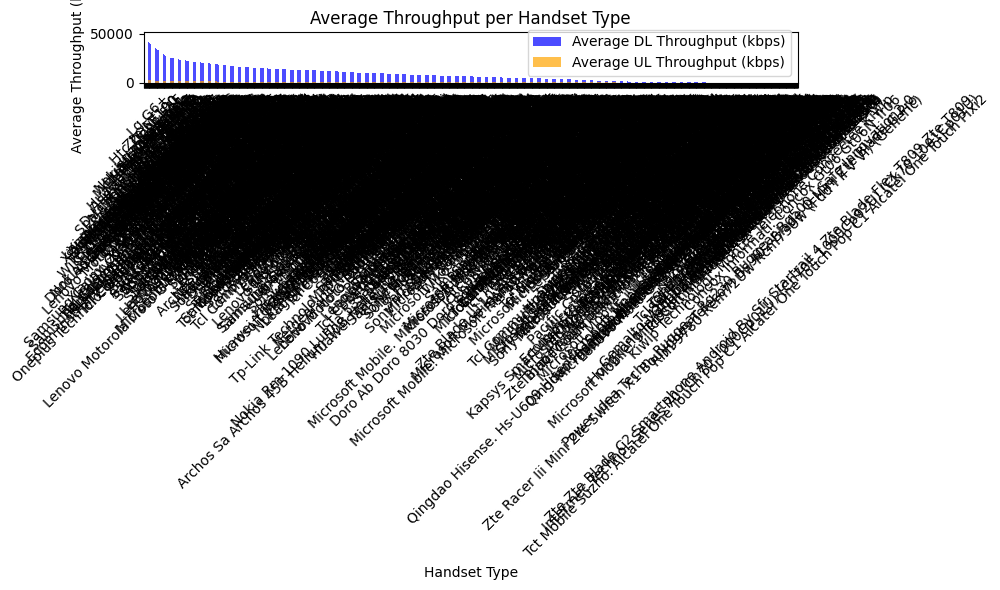

In [11]:
# Plot the throughput per handset type
plot_throughput_per_handset(cleaned_data)

### Plotting TCP retransmissions per handset

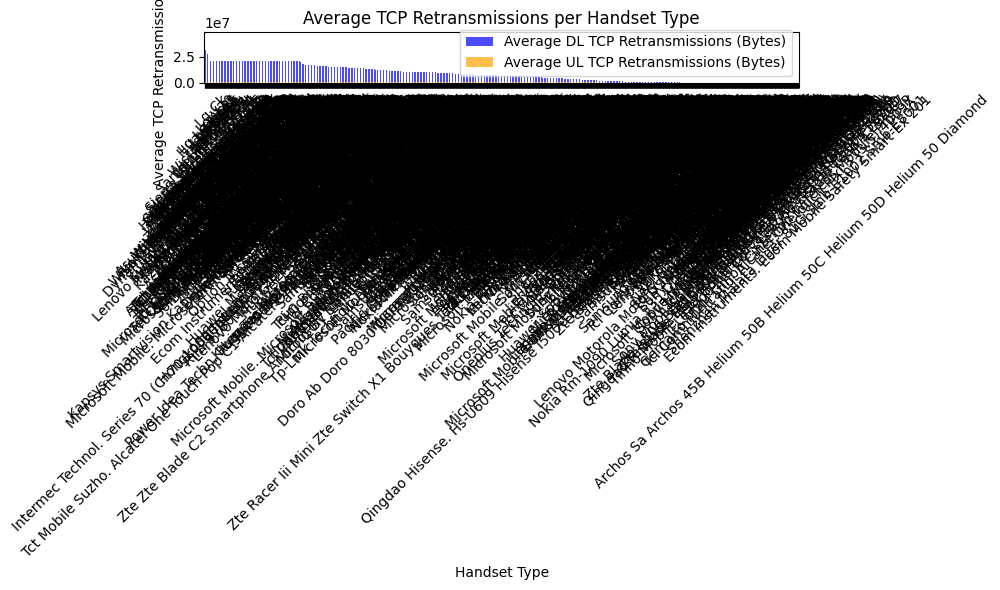

In [12]:
# Plot the TCP retransmissions per handset type
plot_tcp_retransmissions_per_handset(data)


### Performing k-means clustering

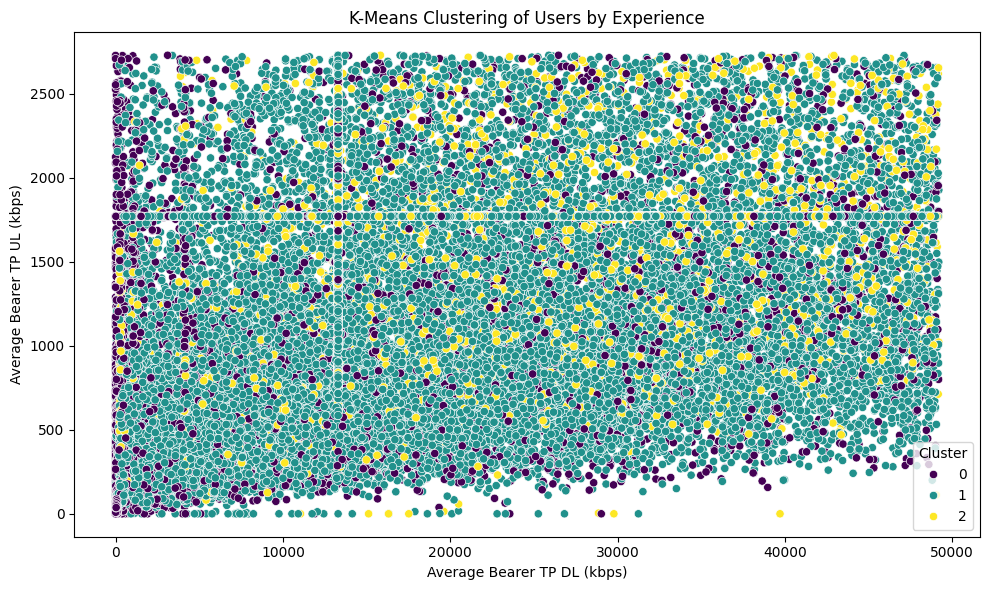

Cluster 1
{'Average TCP DL Retransmissions': np.float64(21050180.877946008), 'Average TCP UL Retransmissions': np.float64(706291.929552369), 'Average RTT DL': np.float64(65.15722283592245), 'Average RTT UL': np.float64(9.441221810282803), 'Average Throughput DL': np.float64(1947.4839529456094), 'Average Throughput UL': np.float64(191.251666679984)}
Cluster 2
{'Average TCP DL Retransmissions': np.float64(745593.0684144683), 'Average TCP UL Retransmissions': np.float64(227603.0222818873), 'Average RTT DL': np.float64(67.58326064423451), 'Average RTT UL': np.float64(12.225408346652053), 'Average Throughput DL': np.float64(17589.617408057195), 'Average Throughput UL': np.float64(1156.6327919897387)}
Cluster 3
{'Average TCP DL Retransmissions': np.float64(8121859.3491304945), 'Average TCP UL Retransmissions': np.float64(210795.02736899973), 'Average RTT DL': np.float64(88.26470864628449), 'Average RTT UL': np.float64(17.307070349024215), 'Average Throughput DL': np.float64(22279.77947700504

In [13]:
cluster_descriptions = perform_kmeans_clustering(cleaned_data, k=3)
for cluster, description in cluster_descriptions.items():
    print(cluster)
    print(description)

The k-means clustering algorithm grouped the dataset into three clusters based on metrics related to user experience, including retransmissions, round-trip time (RTT), and throughput. Each cluster highlights users with similar network performance characteristics.

### Cluster Descriptions
1. **Cluster 1**:
   - **Average TCP DL Retransmissions**: 21,050,180.88 bytes
   - **Average TCP UL Retransmissions**: 706,291.93 bytes
   - **Average RTT DL**: 65.16 ms
   - **Average RTT UL**: 9.44 ms
   - **Average Throughput DL**: 1,947.48 kbps
   - **Average Throughput UL**: 191.25 kbps

   **Insight**: 
   - This cluster represents users with moderate retransmissions and low RTT. 
   - Throughput values are moderate, suggesting balanced network performance.

2. **Cluster 2**:
   - **Average TCP DL Retransmissions**: 745,593.07 bytes
   - **Average TCP UL Retransmissions**: 227,603.02 bytes
   - **Average RTT DL**: 67.58 ms
   - **Average RTT UL**: 12.23 ms
   - **Average Throughput DL**: 17,589.62 kbps
   - **Average Throughput UL**: 1,156.63 kbps

   **Insight**: 
   - Users in this cluster exhibit lower retransmissions but slightly higher RTT compared to Cluster 1.
   - High throughput values indicate better overall network performance, likely for high-speed connections.

3. **Cluster 3**:
   - **Average TCP DL Retransmissions**: 8,121,859.35 bytes
   - **Average TCP UL Retransmissions**: 210,795.03 bytes
   - **Average RTT DL**: 88.26 ms
   - **Average RTT UL**: 17.31 ms
   - **Average Throughput DL**: 22,279.78 kbps
   - **Average Throughput UL**: 1,577.29 kbps

   **Insight**: 
   - This cluster represents users with high retransmissions and RTT, indicating possible network instability or congestion.
   - However, the highest throughput values suggest these users are on high-capacity connections, potentially experiencing trade-offs between speed and reliability.